# Модель на CatBoost

## Навигация

1. [Предобработка](#Предобработка)
2. [Train/test split](#Train/test-split)
3. [Обучение](#Обучение)
   - [Оптимизация гиперпараметров с optuna](#Оптимизация-гиперпараметров-с-optuna)
4. [Model prefomance](#Model-prefomance)
5. [Оценка значимости признаков](#Оценка-значимости-признаков)
   - [PredictionValuesChange](#PredictionValuesChange)
   - [SHAP values](#SHAP-values)

In [1]:
import warnings
warnings.filterwarnings('ignore', message=".*The 'nopython' keyword.*")

import catboost
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import optuna
import pandas as pd
import shap

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import utils

In [2]:
RANDOM_STATE = 42

In [3]:
data = pd.read_excel(utils.constants.ETLED_DATA_PATH)

## Предобработка

[Навигация](#Навигация)

Для категориальных признаков у CatBoost есть ограничение: они должны быть либо `int`, либо `str`, `float` и пропуски не допускаются. Поэтому пропуски я меняю на `-1`.  
Ещё здесь я делаю необязательный Label Encoding. На поведение CatBoost это повлиять не должно, однако для оценки значимости признаков это весьма полезно: на графиках `shap.summary_plot()` для отдельных классов точки будут отрисованы не серым цветом, а согласно значению кода.

In [4]:
for feature in utils.constants.BINARY_FEATURES:
    if  data[feature].isna().sum():
        data[feature] = data[feature].replace({np.NaN: -1})
    data[feature] = data[feature].replace({utils.constants.YES: 1, utils.constants.NO: 0})

data.replace({
    utils.constants.QUESTION_3:
    {
        utils.constants.ANSWER_3_1: 0,
        utils.constants.ANSWER_3_2: 1,
        utils.constants.ANSWER_3_3: 2,
        utils.constants.ANSWER_3_4: 3,
        utils.constants.ANSWER_3_5: 4,
    },
    utils.constants.QUESTION_5:
    {
        np.NaN: -1,
        utils.constants.ANSWER_5_5: 0,
        utils.constants.ANSWER_5_4: 1,
        utils.constants.ANSWER_5_3: 2,
        utils.constants.ANSWER_5_2: 3,
        utils.constants.ANSWER_5_1: 4,
    },
    utils.constants.QUESTION_7:
    {
        np.NaN: -1,
        utils.constants.ANSWER_7_6: 0,
        utils.constants.ANSWER_7_5: 1,
        utils.constants.ANSWER_7_4: 2,
        utils.constants.ANSWER_7_3: 3,
        utils.constants.ANSWER_7_2: 4,
        utils.constants.ANSWER_7_1: 5,
    },
    utils.constants.QUESTION_9:
    {
        np.NaN: -1,
    },
    utils.constants.QUESTION_11:
    {
        np.NaN: -1,
        utils.constants.ANSWER_11_6: 0,
        utils.constants.ANSWER_11_5: 1,
        utils.constants.ANSWER_11_4: 2,
        utils.constants.ANSWER_11_3: 3,
        utils.constants.ANSWER_11_2: 4,
        utils.constants.ANSWER_11_1: 5,
    },
    utils.constants.QUESTION_12:
    {
        np.NaN: -1,
        utils.constants.ANSWER_12_1: 0,
        utils.constants.ANSWER_12_2: 1,
        utils.constants.ANSWER_12_3: 2,
        utils.constants.ANSWER_12_4: 3,
    },
    utils.constants.QUESTION_13:
    {
        np.NaN: -1,
        utils.constants.ANSWER_13_7: 0,
        utils.constants.ANSWER_13_6: 1,
        utils.constants.ANSWER_13_5: 2,
        utils.constants.ANSWER_13_4: 3,
        utils.constants.ANSWER_13_3: 4,
        utils.constants.ANSWER_13_2: 5,
        utils.constants.ANSWER_13_1: 6,
    },
    utils.constants.QUESTION_14:
    {
        np.NaN: -1,
        utils.constants.ANSWER_14_4: 0,
        utils.constants.ANSWER_14_3: 1,
        utils.constants.ANSWER_14_2: 2,
        utils.constants.ANSWER_14_1: 3,
    },
    utils.constants.QUESTION_16:
    {
        np.NaN: -1,
    },
    utils.constants.QUESTION_17:
    {
        np.NaN: -1,
    },
    utils.constants.QUESTION_18:
    {
        np.NaN: -1,
    },
    utils.constants.QUESTION_19:
    {
        np.NaN: -1,
        utils.constants.ANSWER_19_20_1: 0,
        utils.constants.ANSWER_19_20_2: 1,
        utils.constants.ANSWER_19_20_3: 2,
        utils.constants.ANSWER_19_20_4: 3,
    },
    utils.constants.QUESTION_20:
    {
        np.NaN: -1,
        utils.constants.ANSWER_19_20_1: 0,
        utils.constants.ANSWER_19_20_2: 1,
        utils.constants.ANSWER_19_20_3: 2,
        utils.constants.ANSWER_19_20_4: 3,
    },
    utils.constants.QUESTION_23:
    {
        np.NaN: -1,
        utils.constants.ANSWER_23_1: 0,
        utils.constants.ANSWER_23_2: 1,
        utils.constants.ANSWER_23_3: 2,
    },
    utils.constants.QUESTION_25:
    {
        np.NaN: -1,
        utils.constants.ANSWER_25_1: 0,
        utils.constants.ANSWER_25_2: 1,
        utils.constants.ANSWER_25_3: 2,
    },
    utils.constants.QUESTION_26:
    {
        np.NaN: -1,
        utils.constants.ANSWER_26_1: 0,
        utils.constants.ANSWER_26_2: 1,
        utils.constants.ANSWER_26_3: 2,
    },
    utils.constants.QUESTION_27:
    {
        np.NaN: -1,
        utils.constants.ANSWER_27_4: 0,
        utils.constants.ANSWER_27_3: 1,
        utils.constants.ANSWER_27_2: 2,
        utils.constants.ANSWER_27_1: 3,
    },
    utils.constants.QUESTION_28:
    {
        np.NaN: -1,
        utils.constants.ANSWER_28_4: 0,
        utils.constants.ANSWER_28_3: 1,
        utils.constants.ANSWER_28_2: 2,
        utils.constants.ANSWER_28_1: 3,
    },
    utils.constants.QUESTION_29:
    {
        np.NaN: -1,
        utils.constants.ANSWER_29_4: 0,
        utils.constants.ANSWER_29_3: 1,
        utils.constants.ANSWER_29_2: 2,
        utils.constants.ANSWER_29_1: 3,
    },
}, inplace=True)

# требование для cat_features быть либо int, либо str
for feature in [
    utils.constants.QUESTION_9, utils.constants.QUESTION_16, utils.constants.QUESTION_17, utils.constants.QUESTION_18,
]:
    data[feature] = data[feature].astype(int)

## Train/test split

[Навигация](#Навигация)

In [5]:
y = data[utils.constants.TARGET]
X = data.drop(columns=utils.constants.TARGET)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=RANDOM_STATE,
)

## Обучение

[Навигация](#Навигация)

### Оптимизация гиперпараметров с optuna

[Навигация](#Навигация)

In [7]:
def get_model(max_depth, early_stopping_rounds):
    model = catboost.CatBoostClassifier(
        cat_features=list(utils.constants.CATEGORICAL_FEATURES | utils.constants.RANK_FEATURES | utils.constants.BINARY_FEATURES),
        random_seed=RANDOM_STATE,
        max_depth=max_depth,
        early_stopping_rounds=early_stopping_rounds,
    )
    
    return model


def objective(trial):
    sss = StratifiedShuffleSplit(n_splits=4, random_state=RANDOM_STATE)
    scores = np.zeros(4)
    for i, (t, v) in enumerate(sss.split(X_train, y_train)):
        model = get_model(
            max_depth=trial.suggest_int('max_depth', 1, 10),
            early_stopping_rounds=trial.suggest_int('early_stopping_rounds', 5, 15),
        )

        train_X = X_train.iloc[t]
        train_y = y_train.iloc[t]

        val_X = X_train.iloc[v]
        val_y = y_train.iloc[v]

        model.fit(train_X, train_y, verbose=False)
        y_pred = model.predict(val_X)
        scores[i] = accuracy_score(val_y, y_pred)

    return scores.mean()

In [8]:
study = optuna.create_study(direction='maximize', study_name='optuna')

[I 2023-06-08 20:58:50,372] A new study created in memory with name: optuna


In [9]:
%%time
study.optimize(objective, n_trials=25, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-06-08 21:03:49,265] Trial 0 finished with value: 0.6111111111111112 and parameters: {'max_depth': 4, 'early_stopping_rounds': 11}. Best is trial 0 with value: 0.6111111111111112.
[I 2023-06-08 21:06:49,003] Trial 1 finished with value: 0.6277777777777778 and parameters: {'max_depth': 5, 'early_stopping_rounds': 7}. Best is trial 1 with value: 0.6277777777777778.
[I 2023-06-08 21:06:51,552] Trial 2 finished with value: 0.6277777777777778 and parameters: {'max_depth': 5, 'early_stopping_rounds': 12}. Best is trial 1 with value: 0.6277777777777778.
[I 2023-06-08 21:07:03,202] Trial 3 finished with value: 0.6277777777777778 and parameters: {'max_depth': 5, 'early_stopping_rounds': 11}. Best is trial 1 with value: 0.6277777777777778.
[I 2023-06-08 21:08:21,084] Trial 6 finished with value: 0.5888888888888888 and parameters: {'max_depth': 2, 'early_stopping_rounds': 5}. Best is trial 1 with value: 0.6277777777777778.
[I 2023-06-08 21:11:03,852] Trial 8 finished with value: 0.61666666

In [10]:
trial = study.best_trial
print('Лучшие гиперпараметры:')
for param, value in trial.params.items():
    print(f'* {param}: {value}')
print(f'Лучший accuracy: {trial.value}')

Лучшие гиперпараметры:
* max_depth: 5
* early_stopping_rounds: 7
Лучший accuracy: 0.6277777777777778


In [11]:
optuna.visualization.plot_optimization_history(study)

### Refit

[Навигация](#Навигация)

In [12]:
model = get_model(**trial.params)
model.fit(X_train, y_train, verbose=False)
model.save_model(utils.constants.CATBOOST)

## Model prefomance

[Навигация](#Навигация)

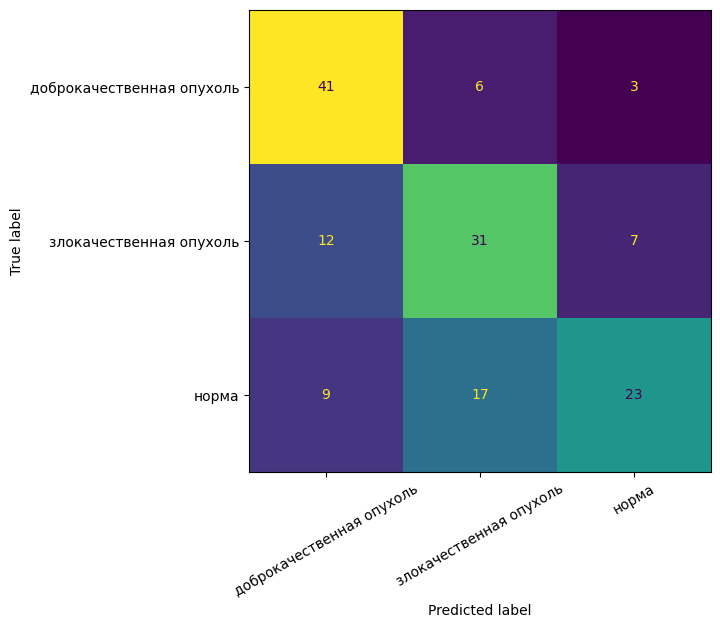

                           precision    recall  f1-score   support

доброкачественная опухоль       0.66      0.82      0.73        50
  злокачественная опухоль       0.57      0.62      0.60        50
                    норма       0.70      0.47      0.56        49

                 accuracy                           0.64       149
                macro avg       0.64      0.64      0.63       149
             weighted avg       0.64      0.64      0.63       149



In [24]:
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(y_test, y_pred))

## Оценка значимости признаков

[Навигация](#Навигация)

### PredictionValuesChange

[Навигация](#Навигация)

In [14]:
prediction_values_change = model.get_feature_importance()

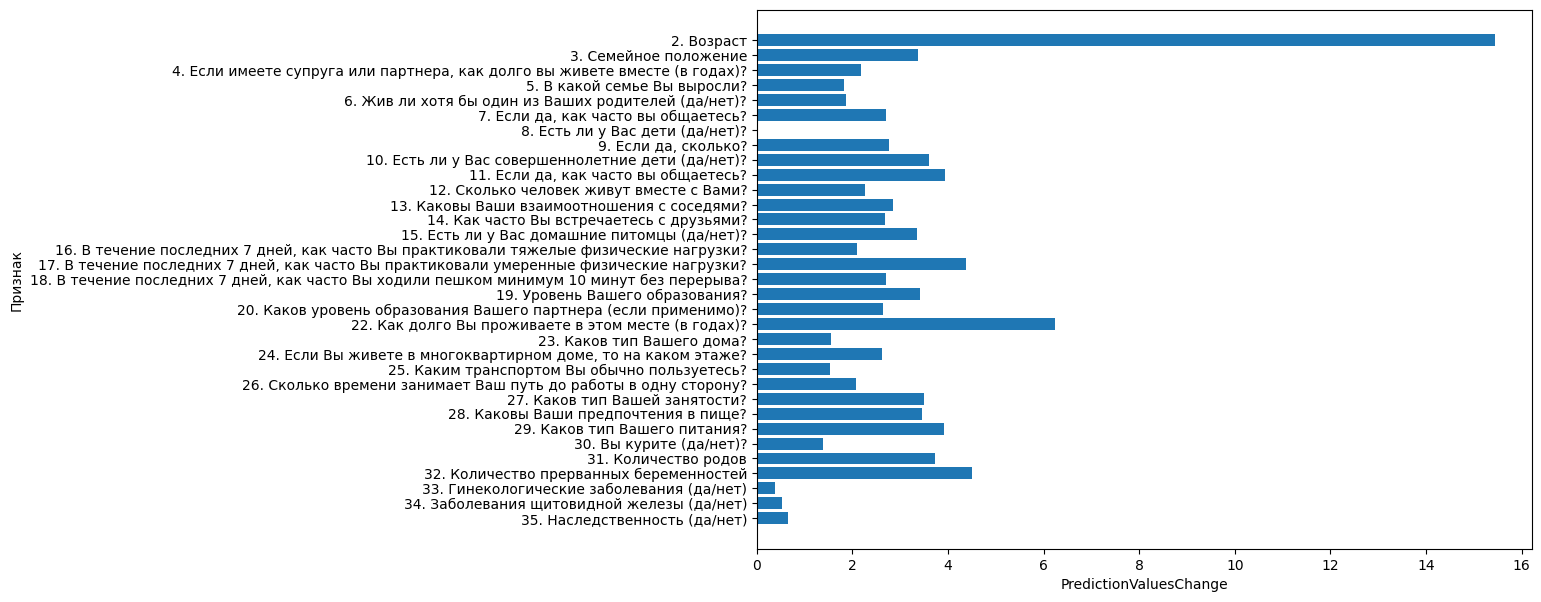

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(list(reversed(utils.constants.FEATURES)), list(reversed(prediction_values_change)), align='center')
ax.set(xlabel='PredictionValuesChange', ylabel='Признак')
plt.show()

### SHAP values

[Навигация](#Навигация)

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:890: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



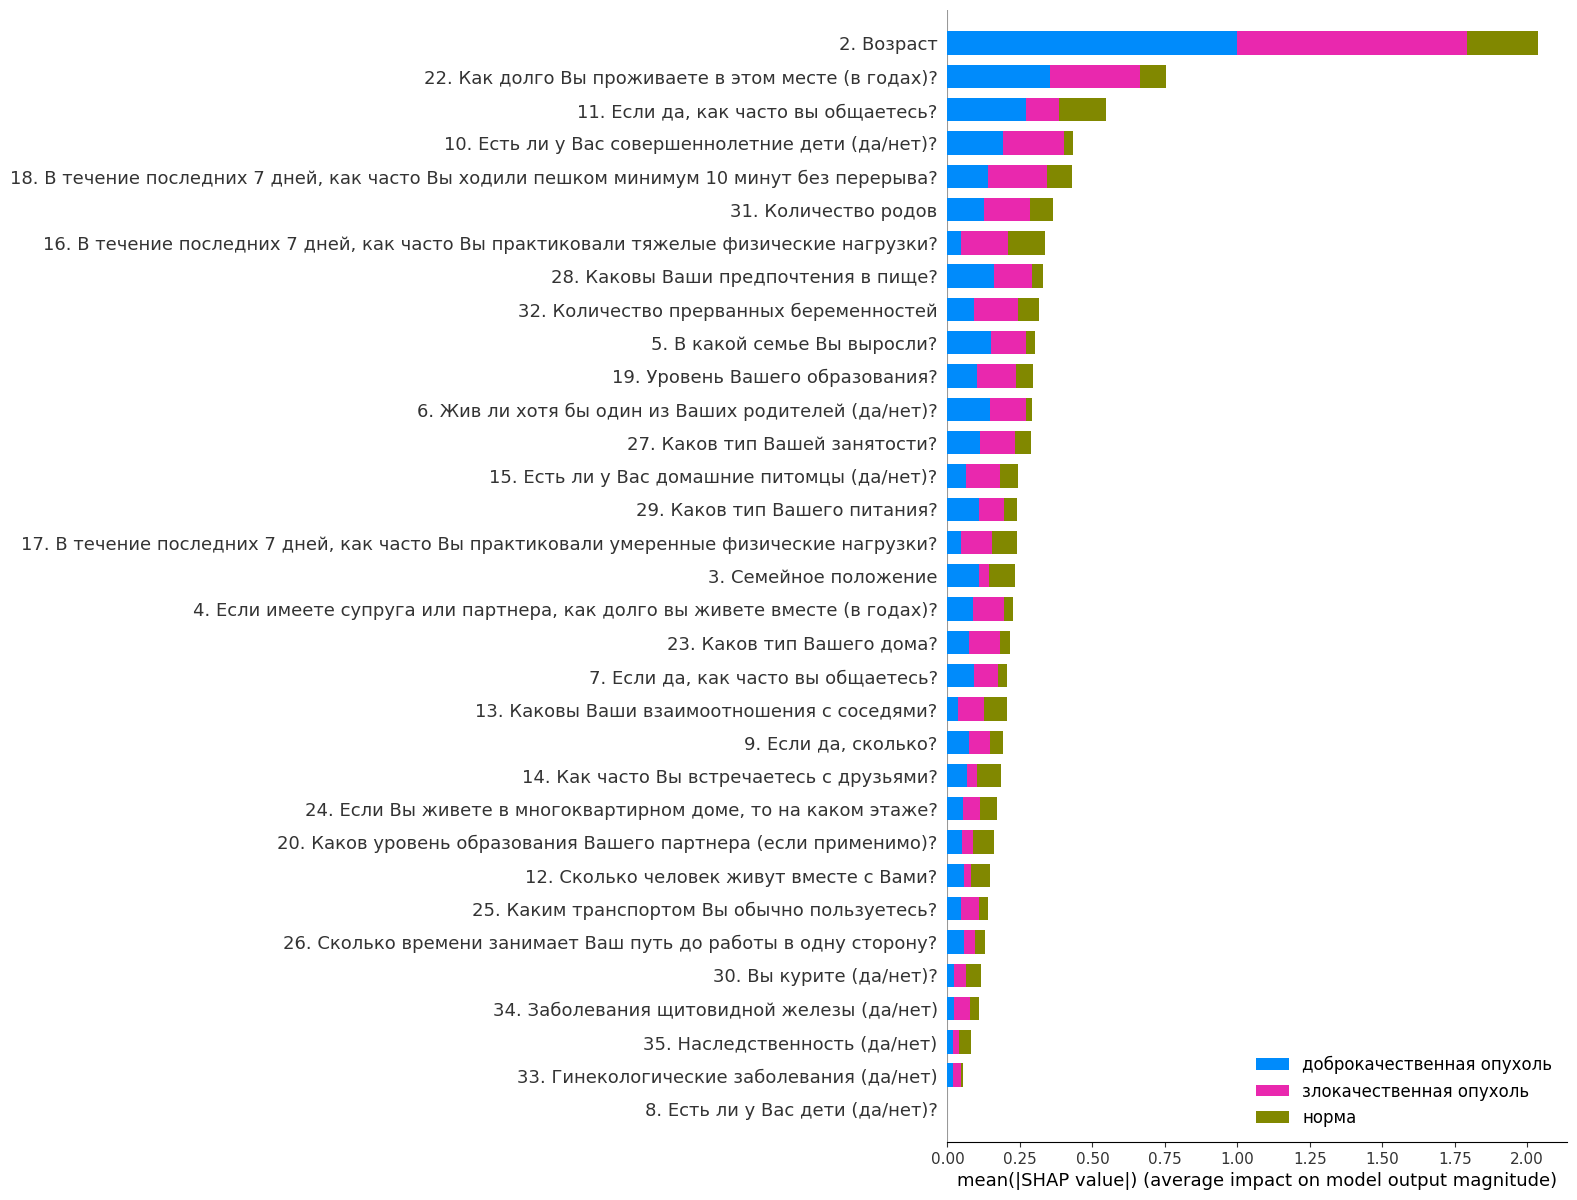

In [17]:
shap.summary_plot(
    shap_values=shap_values,
    features=X,
    max_display=33,
    class_names=list(sorted(utils.constants.LABELS)),
)

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:890: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



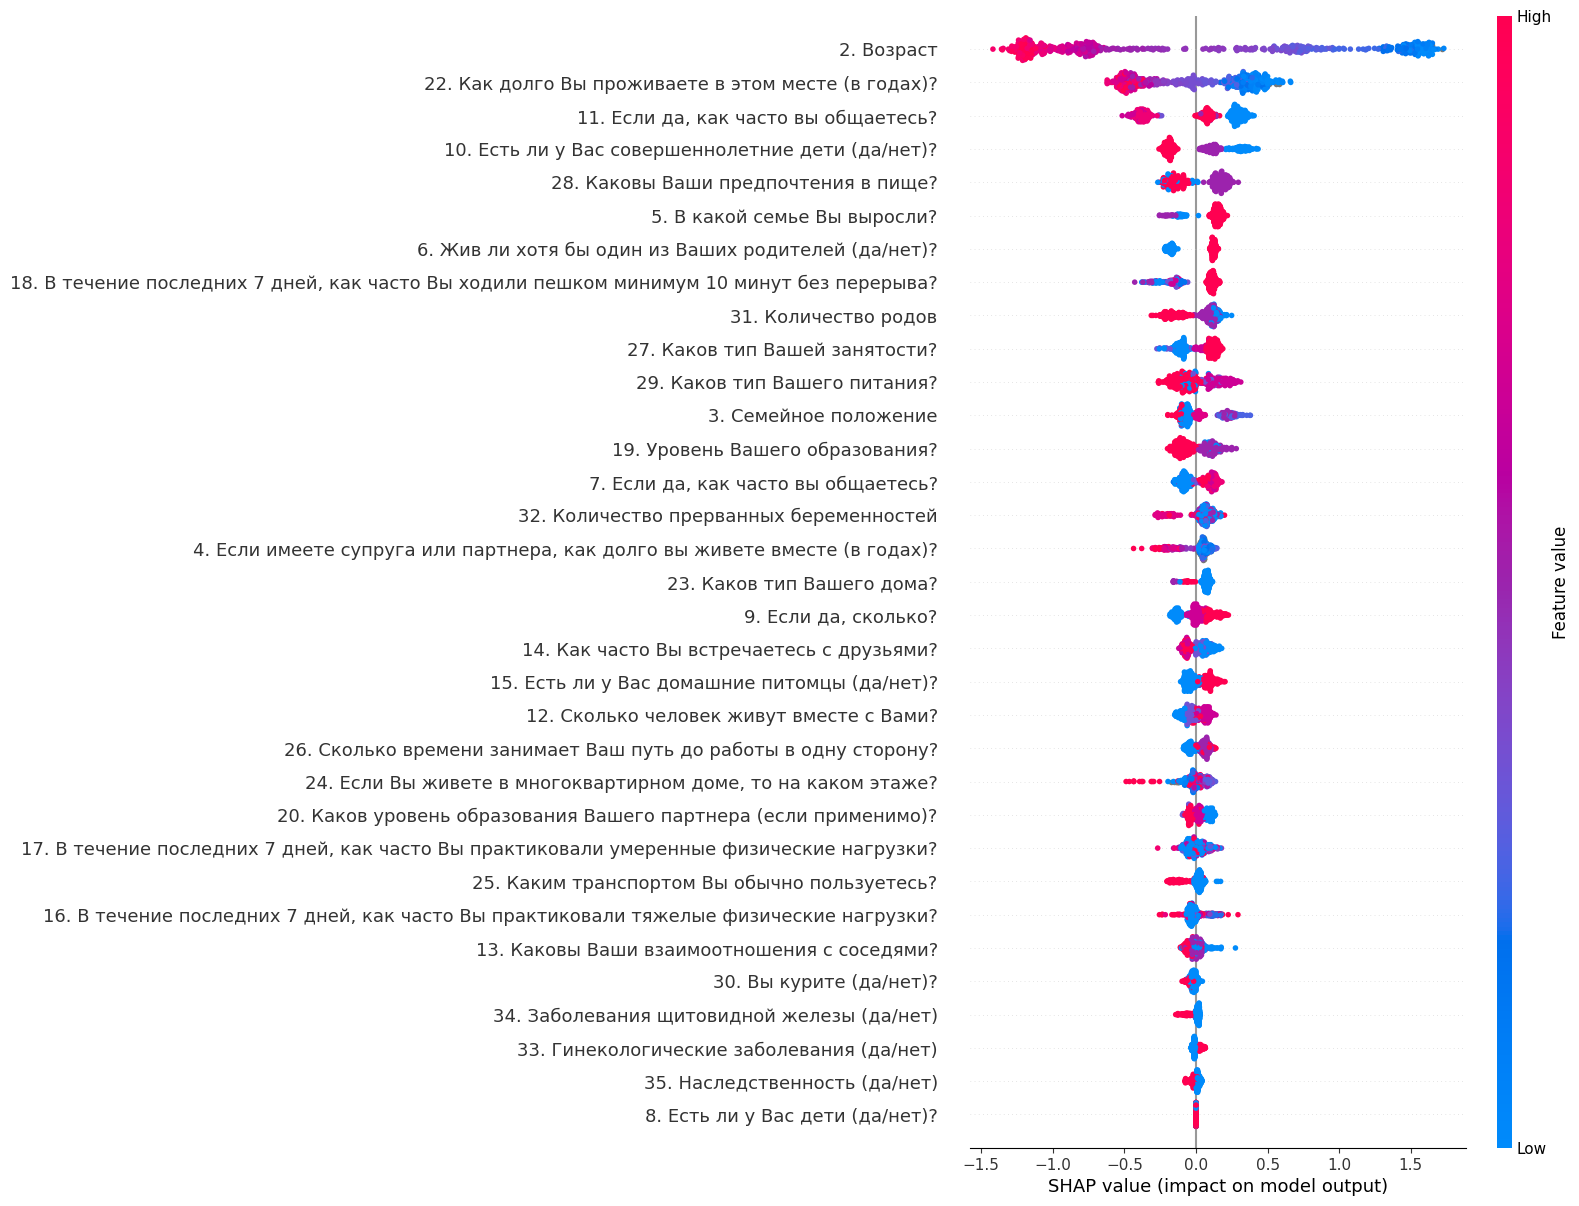

In [18]:
shap.summary_plot(shap_values=shap_values[0], features=X, max_display=33)

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:890: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



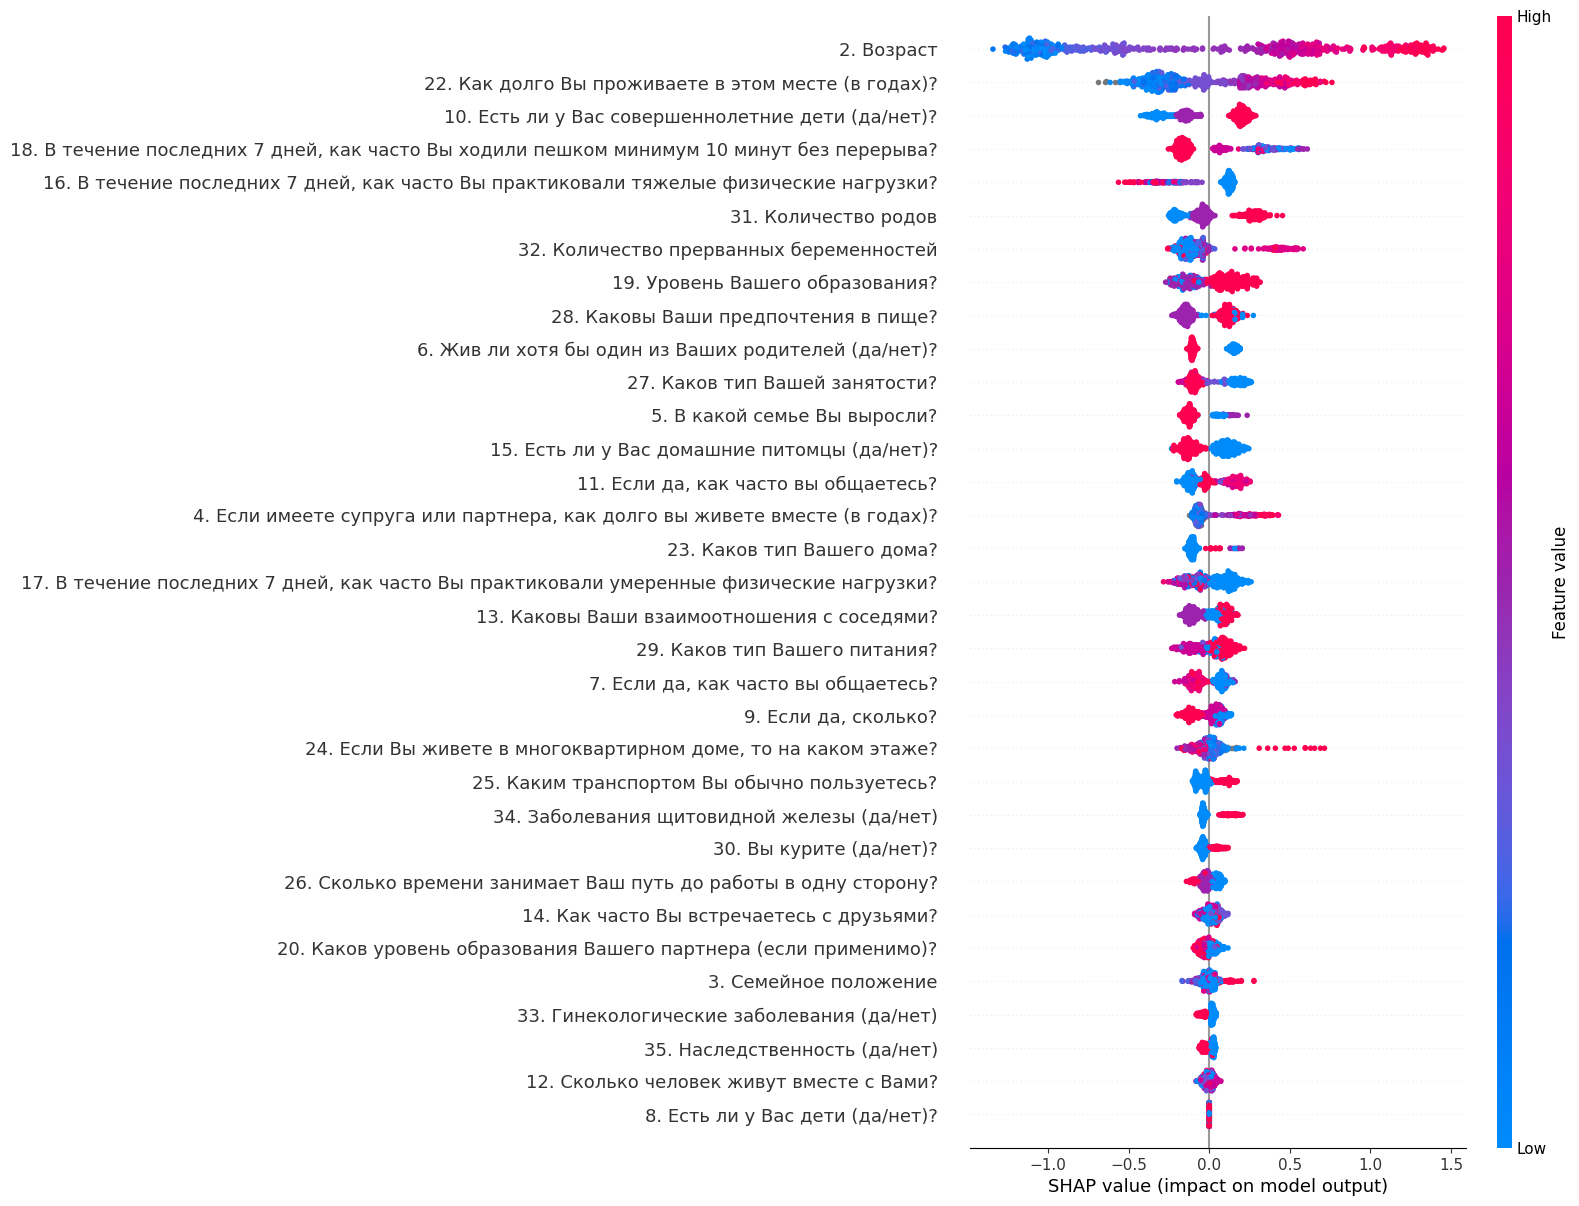

In [19]:
shap.summary_plot(shap_values=shap_values[1], features=X, max_display=33)

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\plots\_beeswarm.py:890: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



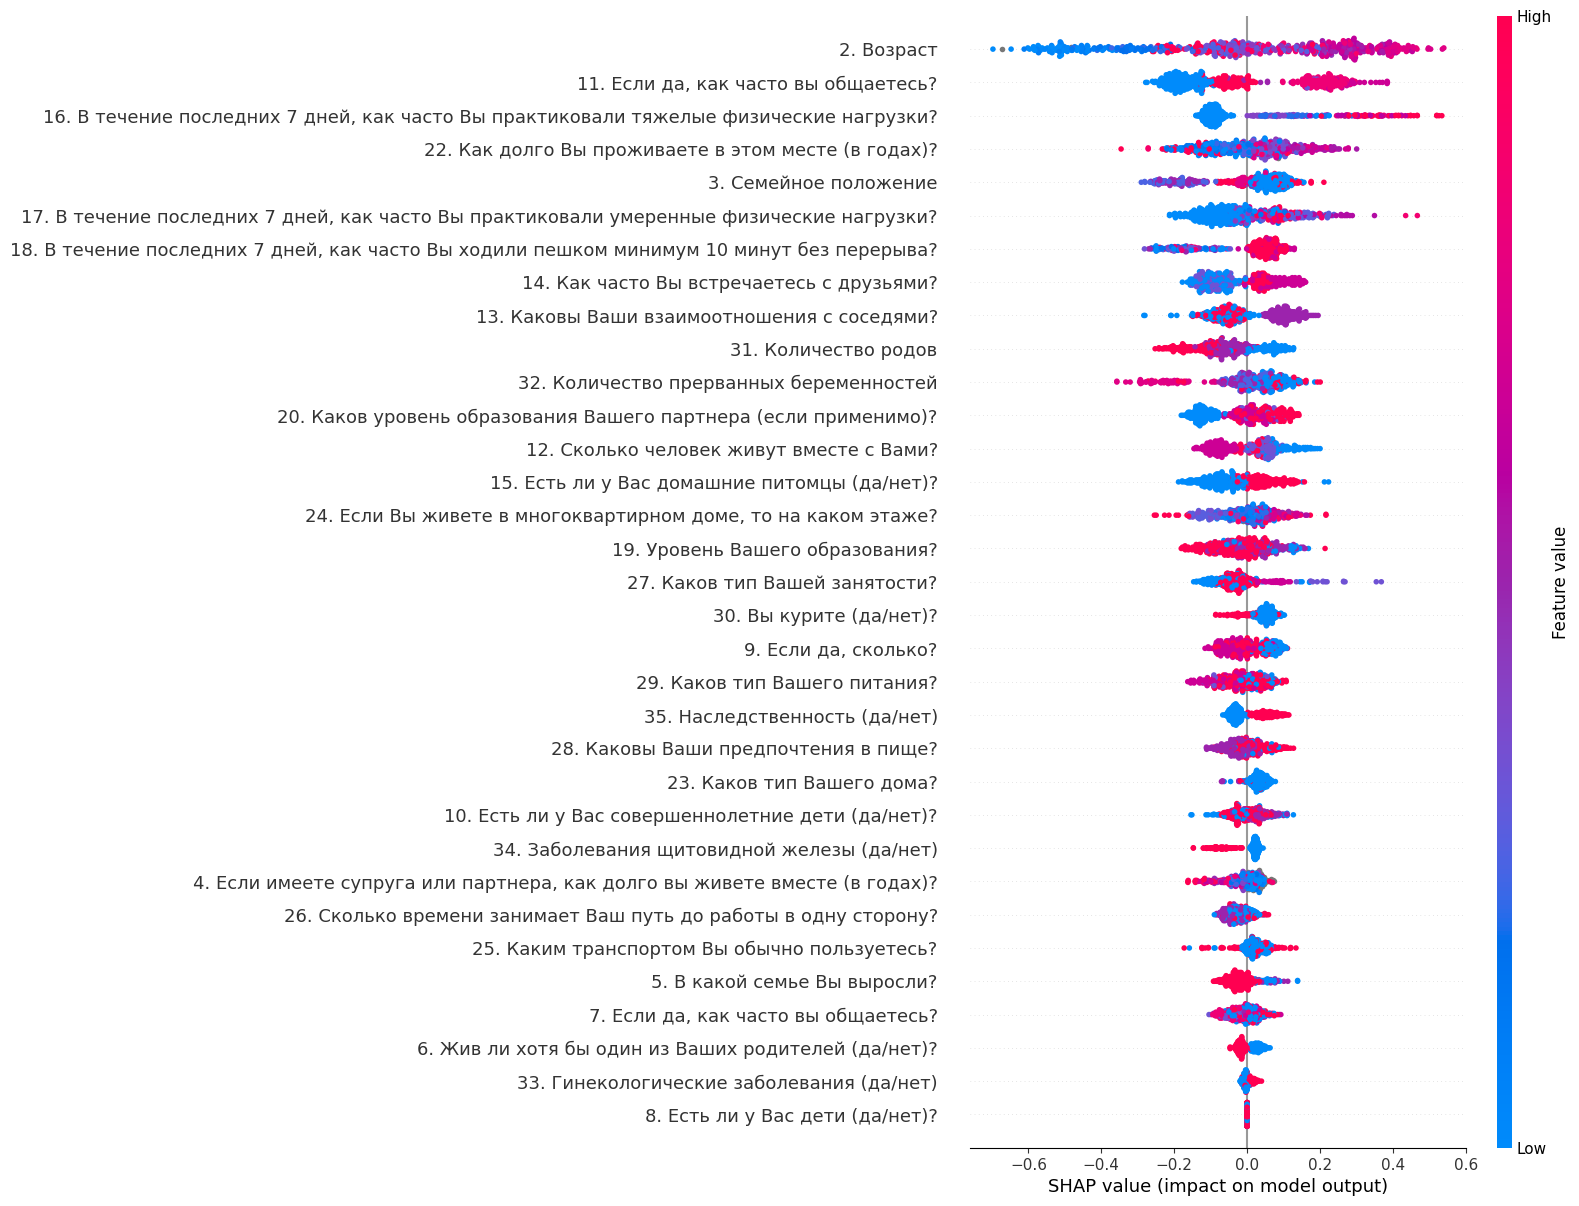

In [20]:
shap.summary_plot(shap_values=shap_values[2], features=X, max_display=33)

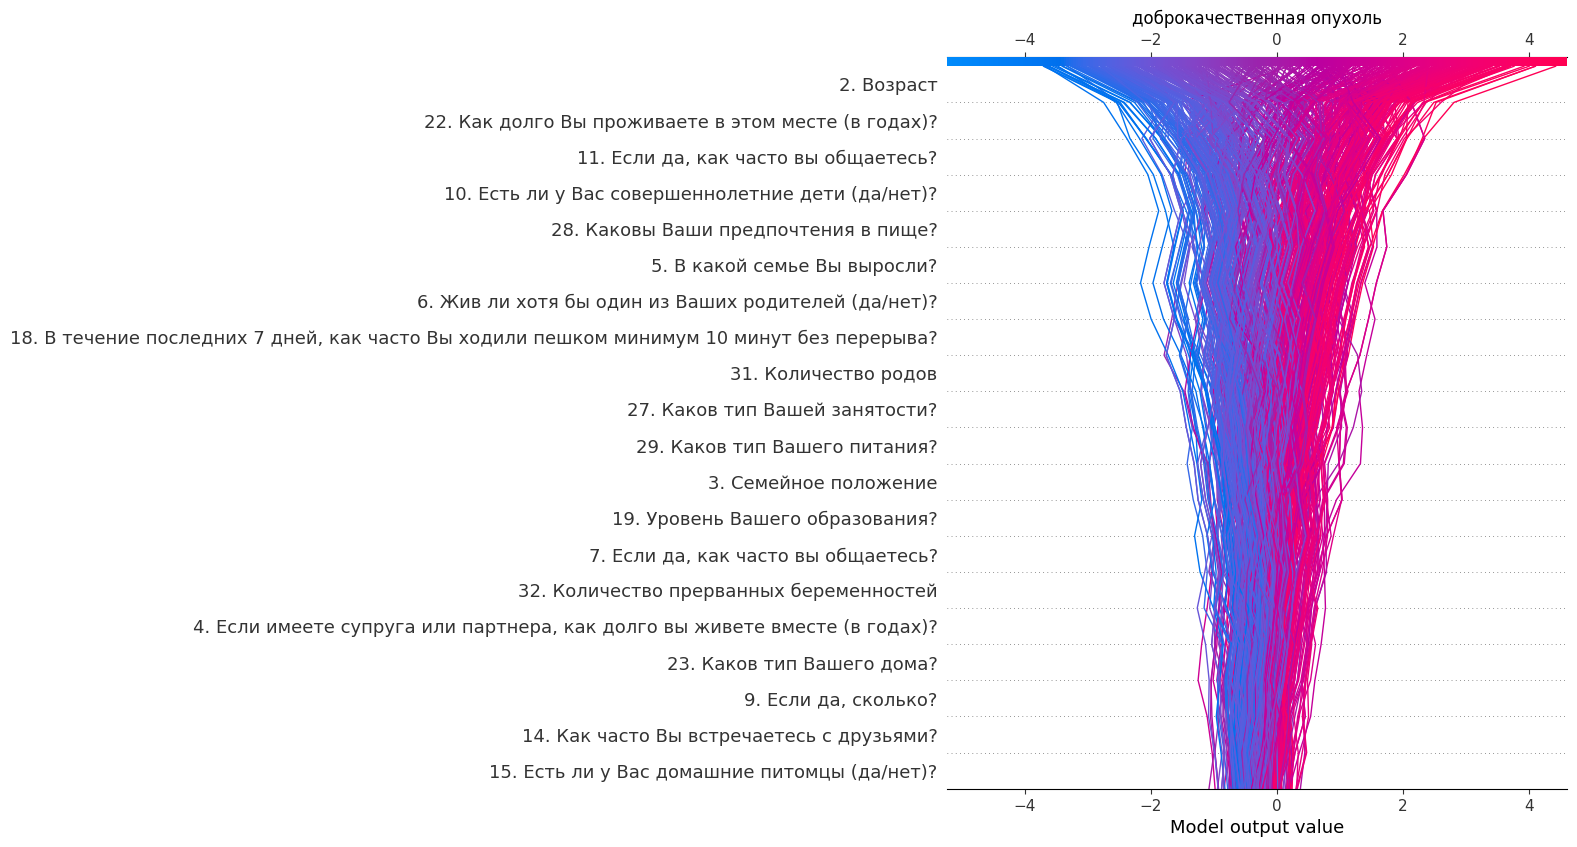

In [21]:
shap.decision_plot(
    expected_value[0],
    shap_values[0],
    utils.constants.FEATURES,
    title=list(sorted(utils.constants.LABELS))[0],
)

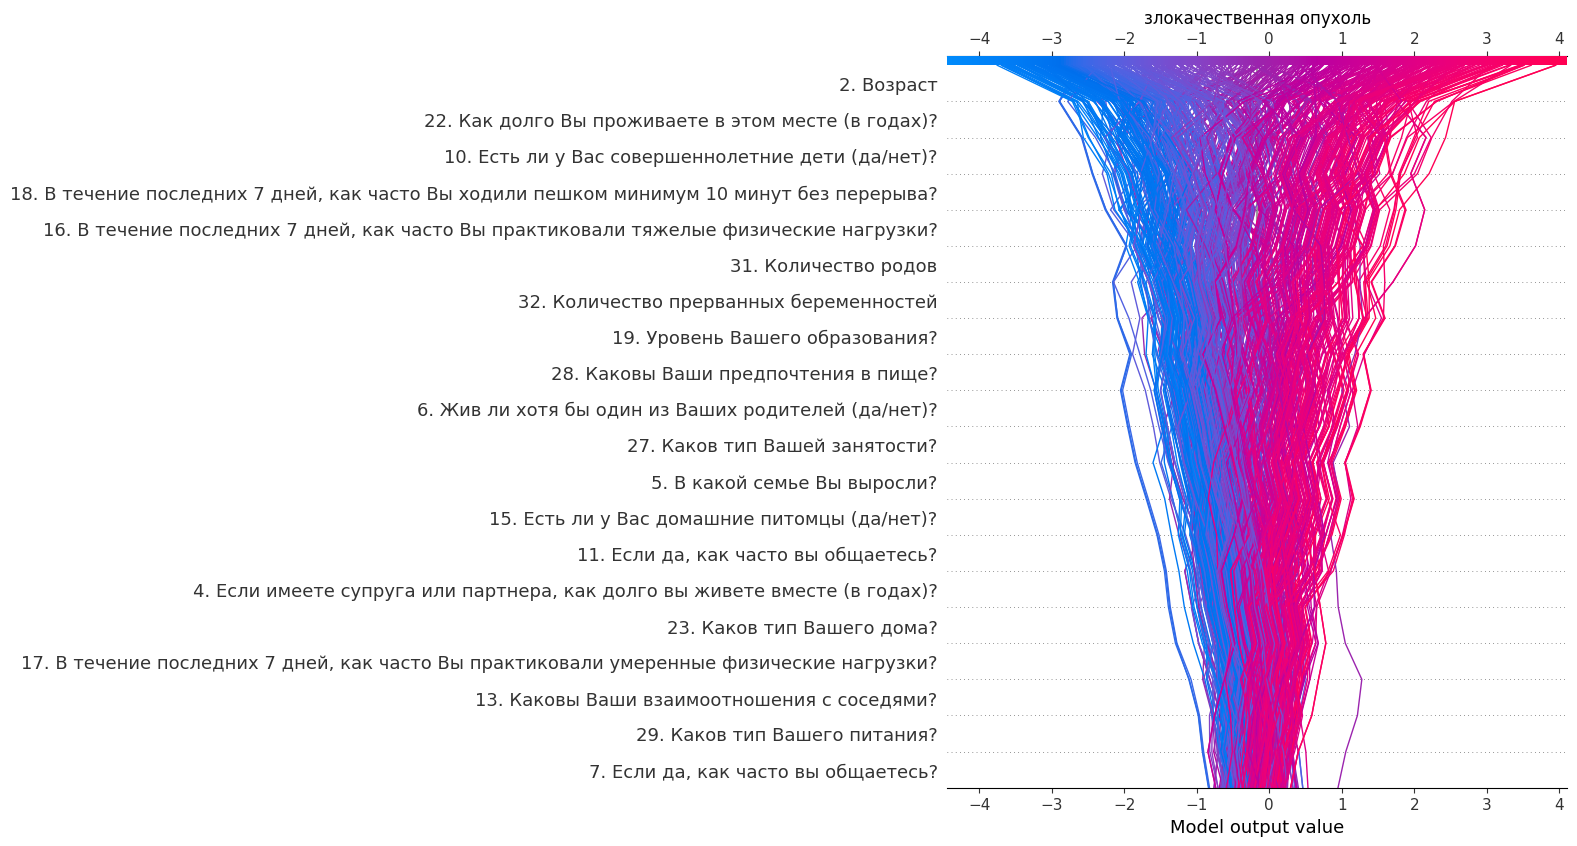

In [22]:
shap.decision_plot(
    expected_value[1],
    shap_values[1],
    utils.constants.FEATURES,
    title=list(sorted(utils.constants.LABELS))[1],
)

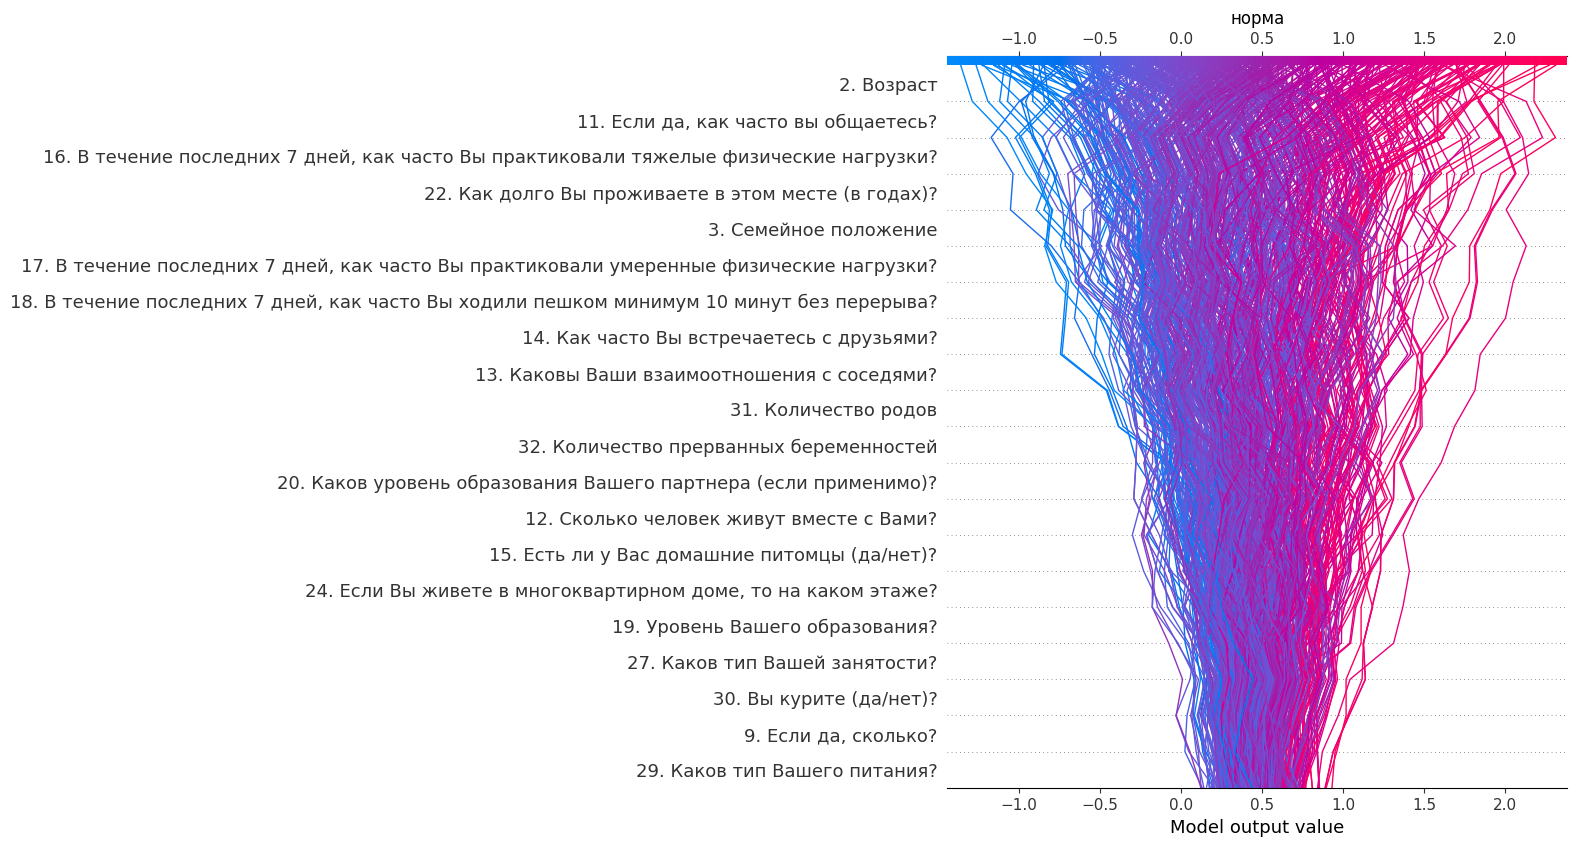

In [23]:
shap.decision_plot(
    expected_value[2],
    shap_values[2],
    utils.constants.FEATURES,
    title=list(sorted(utils.constants.LABELS))[2],
)